# 

# Picking the Best Predictive Model:  A Case Study in Analytics Operationalization 

## Part 3. Machine Learning Modeling of Remaining Useful Life

### Author: Craig Adams
#### Contact: craig.adams@elementaryinsights.com
#### Date: July 5, 2022

### Table of Contents

[Introduction](#Introduction) <br>
[Methodology](#Methodology) <br>
[Results and Discussion](#Results-and-Discussion) <br>
- [Decision Tree Modeling](#Decision-Tree-Modeling) <br>
- [The Full Data Science ML solution](#The-Full-Data-Science-ML-solution)<br>

[Summary](#Summary) <br>

###  Introduction

[go to top](#Table-of-Contents) <br>

>"*All models are wrong, some are useful, and some are more cost effective than others - Unknown*"

As detailed in Part 1, the goal of this study is to explore the development of different analytical solutions for a particular business problem, ranging from the simplest techniques to more complex ML models.  The case study is the prediction of failures of jet engines for a fictious client, Jetsonair.  The owner wants to use AI to help predict the failures of the engines which are causing issues with the customers.  The CEO wants to first understand the options available for his team to be able to remove the engines from service before the failure, but at the same time, not give up too much of the useful life of the engines (Figure 1).

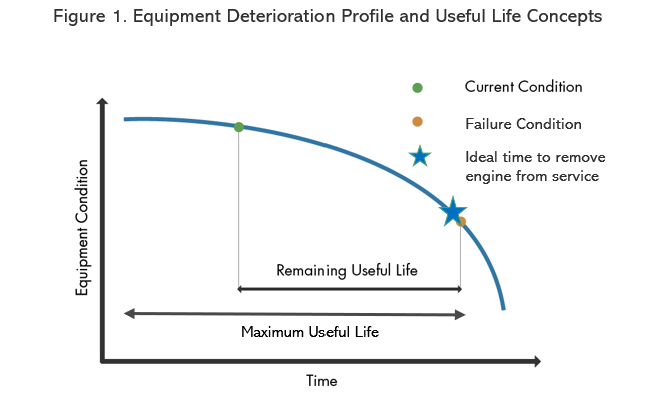


In Part 2, four different scenarios were explored with the client's engine failure data.  The first three were as follows:

 - The "Do Nothing" base case where the full 20,531 cycles of operation would be realized but with 100% chance of failure on the last cycle for each engine at a semi-random interval between 127 and 361 cycles.
 
 - The "Weibull" analysis method where 13,000 cycles or 64% of the fleet's available useful life would be utilized with only 1 in 100 failures. 

 - The "Sensor Alert" statistical model that uses a specific threshold value for `sensor 11` of 47.936 to remove engines from service.  This results in 83% operating efficiency in using the uselife of the engines with an elevated risk of failure at ~2 times in 100 yet no failures in the data. 
    
The Sensor Alert is a practical approach that would conceivably work well when deployed, similar to a check engine light on a car.  When deployed, other more sophisticated solutions would need to improve on that solution's performance by competing for the remaining 17% operating life on an incremental cost-benefit basis.

In that regard, an attempt was made to predict RUL as a numeric value using a tangential linear regression model with the simple linear equation:  

  $$ \hat{y} = -2053 + (-38.65) sensor 11 + (7.55) sensor 12  $$
 
Unfortunately, the predicted values for RUL were inaccurate even as RUL approached zero and the model still didn't pass all of the statistical requirements for Linear Regression.  Yet there was potential for the model to be useful by creating a business rule from the biased-high RUL predictions:

                        "If the predicted RUL reaches 15 or less, then remove engine from service"
                
The operating efficiency increased to 92% of available cycles with this approach, but there was one big failure where the tangential regression model failed to flag an engine by a wide margin. 
    
Despite the poor results, the concept that was used was strong: the linear regression model was essentially turned into a classifier. There are other more sophisticated ways to build classifiers with Machine Learning, which will be the focus of Part 3.

### Methodology

[go to top](#Table-of-Contents) <br>

The typical Machine Learning modeling workflow is as follows:  

1. Splitting the data into test and train sets
2. Feature extraction and creation if required
3. Scaling the data using the train set
4. Choosing and fitting a model to the train set
5. Parameter tuning if possible or required
6. Scoring the model against the test set

Step 1 will be done once, while steps 2 to 5 will be followed and iterated upon for the subsequent modeling attempts as needed with a final Step 6 in each case once an optimal model has been picked.



In [1]:
### Python Configuration

# Import relevant packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import plot_roc_curve

# Set environment variables
import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (8, 6)

### Results and Discussion

[go to top](#Table-of-Contents) <br>

#### Data Ingestion

The ML development process begins with loading the cleaned data set from Part 1.

In [2]:
# Import the data from the project directory
load_file = './data/failure_cleaned.csv'
failure_df_raw = pd.read_csv(load_file)

# Quick check of the cleaned dataset to make sure it loaded correctly
display(failure_df_raw.head())
print(f"The dataframe shape is {failure_df_raw.shape[0]} rows and {failure_df_raw.shape[1]} columns\n")
display(failure_df_raw.describe().T)

,unit_number,cycle_time,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


The dataframe shape is 20631 rows and 15 columns



,count,mean,std,min,25%,50%,75%,max
unit_number,20631.0,51.506568,29.227633,1.0000,26.0000,52.0000,77.0000,100.0000
cycle_time,20631.0,108.807862,68.880990,1.0000,52.0000,104.0000,156.0000,362.0000
sensor_2,20631.0,642.680934,0.500053,641.2100,642.3250,642.6400,643.0000,644.5300
sensor_3,20631.0,1590.523119,6.131150,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor_4,20631.0,1408.933782,9.000605,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor_7,20631.0,553.367711,0.885092,549.8500,552.8100,553.4400,554.0100,556.0600
sensor_8,20631.0,2388.096652,0.070985,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
sensor_11,20631.0,47.541168,0.267087,46.8500,47.3500,47.5100,47.7000,48.5300
sensor_12,20631.0,521.413470,0.737553,518.6900,520.9600,521.4800,521.9500,523.3800
sensor_13,20631.0,2388.096152,0.071919,2387.8800,2388.0400,2388.0900,2388.1400,2388.5600



#### Step 1. Splitting the data into test and train sets

As mentioned in Part 1, the native FD_001 test set from NASA does not include any engines that failed and few that are close to failure.  However, guidance can be taken from the nature of that test set to recognize that splitting the data in this context needs to be by engine since it is time series data.  Splitting the data in the typical random train_test_split fashion will not work.  

There is a business argument for splitting the data by excising the records for the last X number of engines rather than randomly.  If there is any bias developing in time due changes in the operating environment, the modeling process should reveal these issues. 

For that reason, the last 20 engines have been chosen to be split out into a new test set dataframe, with the first 80 engines assigned to the training set.


In [3]:
# Create engine list
split = 81
split_list = np.arange(split,101,1)
# print(f"Test set engines: {split_list}")
print(f"Test set engine count: {len(split_list)}")


Test set engine count: 20


In [4]:
# Create copy of the cleaned dataframe
failure_df = failure_df_raw.copy()

# Split out the data for engines 81 to 100
failure_train = failure_df[~(failure_df['unit_number'].isin(split_list))]
failure_test = failure_df[failure_df['unit_number'].isin(split_list)]

# print(failure_train['unit_number'].nunique())
# print(failure_test['unit_number'].nunique())

#### Step 2. Feature extraction and creation if required

For classification models, a Failure Threshold needs to be created as the target variable.  For convenience, this will be added to both the training and test set, in addition to the Sensor Alert from Part 2 which will be used for comparison purposes later.  

Borrowing from the tangential modeling in Part 2, the initial failure threshold will be set to 15.  All training records with RUL values at or below that value will be considered to be part of the Class 1 Failure class, while records with RUL values above that threshold will be part of the Class 0 Normal class.

##### Helper Functions

In [5]:
def set_thresholds(df, failure_threshold, sensor_11_alert=47.936):
    """ This function adds the Failure Threshold and Sensor Alert binary values in two columns to a prescribed dataframe
    """
    # Add features to train or test df
    df['Failure_Threshold'] = np.where(df['RUL'] <= failure_threshold, 1,0)
    df['sensor_11_alert'] = np.where(df['sensor_11'] >= sensor_11_alert, 1,0)
    
    return df


In [6]:
def split_data(df):
    """ This function drops columns that are not required for modeling and splits out the Failure Threshold target variable
    """
    X = df.drop(['unit_number','RUL', 'Failure_Threshold','cycle_time','sensor_11_alert'], axis=1)
    y = df['Failure_Threshold']
    
    return X,y

In [7]:
# Set Failure threshold and sensor alert thresholds  
failure_threshold = 15
sensor_11_alert = 47.936

# Set thresholds in training set
failure_train = set_thresholds(failure_train, failure_threshold)

# Set thresholds in test set
failure_test = set_thresholds(failure_test, failure_threshold)

Note that there will be a class imbalance in the data sets as only about 8% of the records are for the threshold of RUL=15 and below.

In [8]:
# See the class balance
print("Balance between Training Set Class 0 No Failure and Class 1 Failure")
print("-"*60)
display(failure_train['Failure_Threshold'].value_counts(normalize=True))

Balance between Training Set Class 0 No Failure and Class 1 Failure
------------------------------------------------------------


0    0.920684
1    0.079316
Name: Failure_Threshold, dtype: float64

#### Step 3. Prepare the data for first model

To prepare for model development, the training data needs to be split into the target variable `Failure Threshold`, and the features, with any non-sensor data columns removed.

In [9]:
# Split the data into X and y
X_train, y_train = split_data(failure_train)

The data is ready for the first attempt at building an ML Failure Prediction classifier

### Decision Tree Modeling

[go to top](#Table-of-Contents) <br>

There are many different classifiers to choose from, but the first one to be tested here is a simple 'vanilla' Decision Tree algorithm.  Decision trees are [very popular](https://www.simplilearn.com/10-algorithms-machine-learning-engineers-need-to-know-article) in business settings, second to logistic regression in classifier popularity.  It has a high explainability for the business decision makers and it is theoretically possible to convert the decision tree logic into new and simple "if-then" business rules that can be programmed into an alert system or learned by a workforce.  If the results are reliable, further modeling is not required.


##### Helper Functions

In [10]:
def model_scoring(model, X_train, y_train, plot=True):
    """ This function take the input classifier model and scores the results on the input X and y dataframes.
    The output also includes the confusion matrix, and the precision, accuracy, recall and F1 scores
    """
    # Evaluate on the original test set
    y_pred = model.predict(X_train)

    if plot == True:
    # Plot Results
        sns.set_style('dark')
        plt.figure(figsize=(8,6))
        plot_confusion_matrix(model, X_train, y_train)
        plt.title("Confusion matrix")
        plt.show()

    print("Classification Report")
    print("-"*60)
    report_initial = classification_report(y_train, y_pred)
    print(report_initial)

    return 


In [11]:
def plot_decision_tree(DT_model, X_train):
    """ This function take the input classifier model and the training data columsn and plots the model's decision tree and 
    the relative feature importances in a simple tabular form. 
    """
    
    fig, ax = plt.subplots(figsize=(20,8))

    plot_tree(DT_model,
              feature_names=X_train.columns,
              rounded=True,
              impurity=True,
              filled=True,
              ax=ax,
              fontsize=15)

    plt.show()
    
    # Show the aggregate coefficients relative to their names
    coefs = (list(zip(X_train.columns,DT_model.feature_importances_)))
    coefs_df = pd.DataFrame(coefs, columns =['sensor','coefficient'])
    display(coefs_df.sort_values(by='coefficient', ascending=False).T)


#### Step 4. Building a Practical Decision Tree Model

In theory, the Decision Tree (DT) model can be set up to fit the entire dataset and build a network of explanatory branches until all records have their own branch.  However, for business applications, there is a practical limit to the logic for programmable 'if/then' business rules. For that reason, the baseline DT model here will have at maximum 3 branches or 9 programmable if/then statements.

Models are tested for 1, 2 and 3 branches to show the progression in results. The default min_samples is one (aka 1 record for a branch). This is not likely a problem given the limit on branches but the results can be checked to see how many records were assigned to each branch in each case. 

The following code block builds the models sequentially, reporting in each case the confusion matrix, the performance metrics of accuracy, precision, recall and F1 score, then the decision tree and the feature importances table for the given model.

--------------------------------------------------------------------------------
Decision tree branches in model: 1


<Figure size 576x432 with 0 Axes>

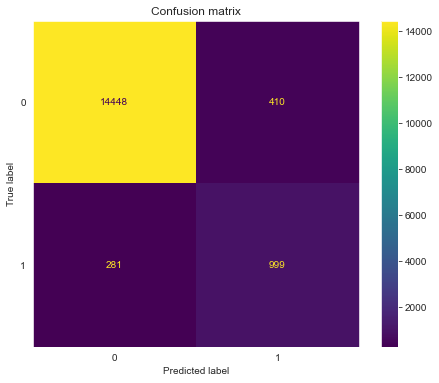

Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     14858
           1       0.71      0.78      0.74      1280

    accuracy                           0.96     16138
   macro avg       0.84      0.88      0.86     16138
weighted avg       0.96      0.96      0.96     16138



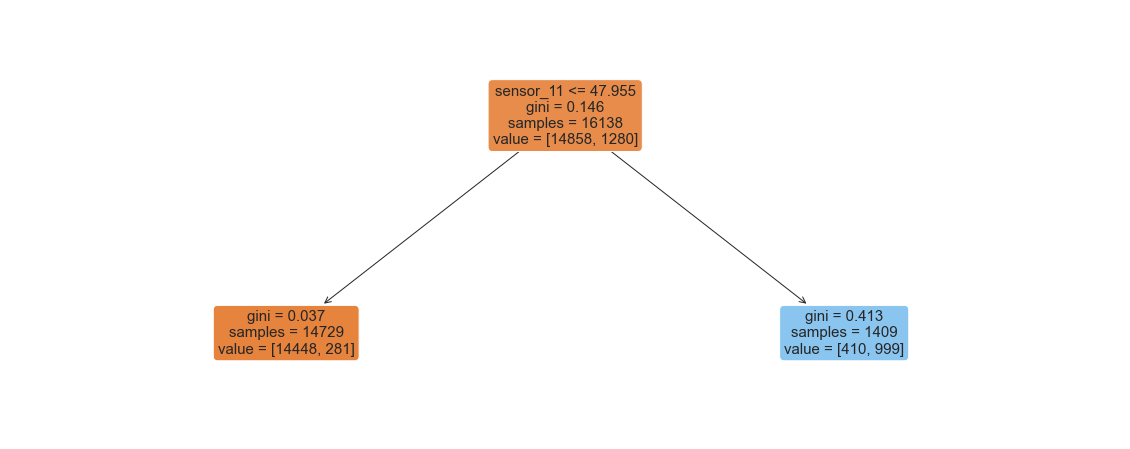

,5,0,1,2,3,4,6,7,8,9,10,11
sensor,sensor_11,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_12,sensor_13,sensor_15,sensor_17,sensor_20,sensor_21
coefficient,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------------------------------------------
Decision tree branches in model: 2


<Figure size 576x432 with 0 Axes>

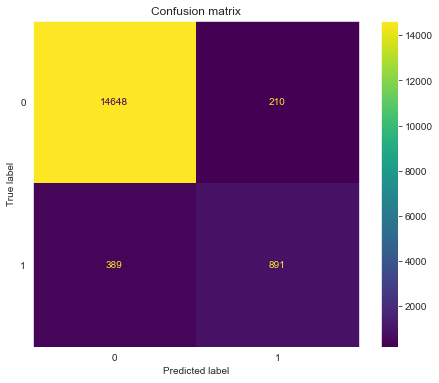

Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14858
           1       0.81      0.70      0.75      1280

    accuracy                           0.96     16138
   macro avg       0.89      0.84      0.86     16138
weighted avg       0.96      0.96      0.96     16138



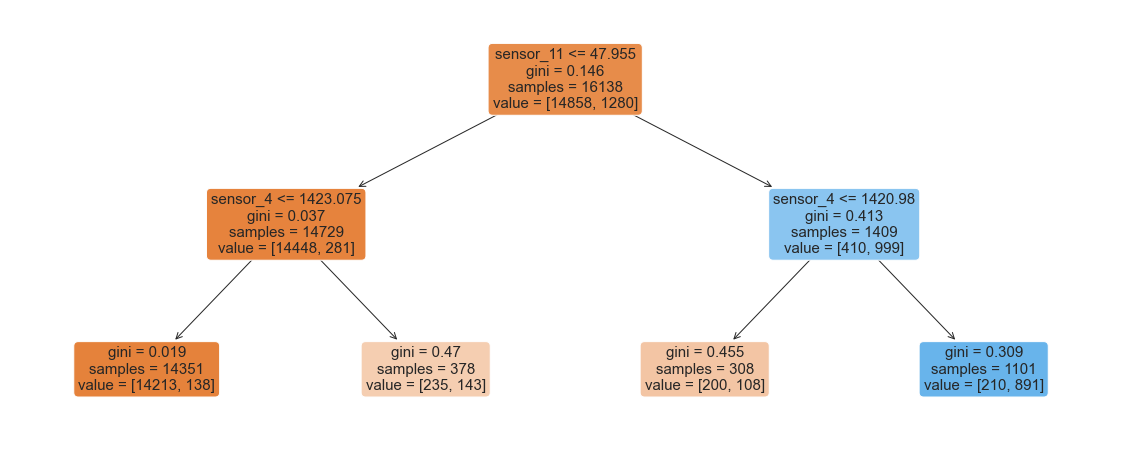

,5,2,0,1,3,4,6,7,8,9,10,11
sensor,sensor_11,sensor_4,sensor_2,sensor_3,sensor_7,sensor_8,sensor_12,sensor_13,sensor_15,sensor_17,sensor_20,sensor_21
coefficient,0.858753,0.141247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


--------------------------------------------------------------------------------
Decision tree branches in model: 3


<Figure size 576x432 with 0 Axes>

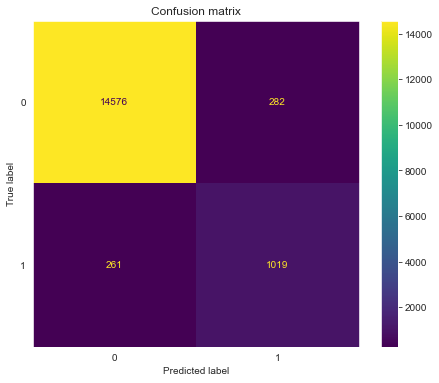

Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14858
           1       0.78      0.80      0.79      1280

    accuracy                           0.97     16138
   macro avg       0.88      0.89      0.89     16138
weighted avg       0.97      0.97      0.97     16138



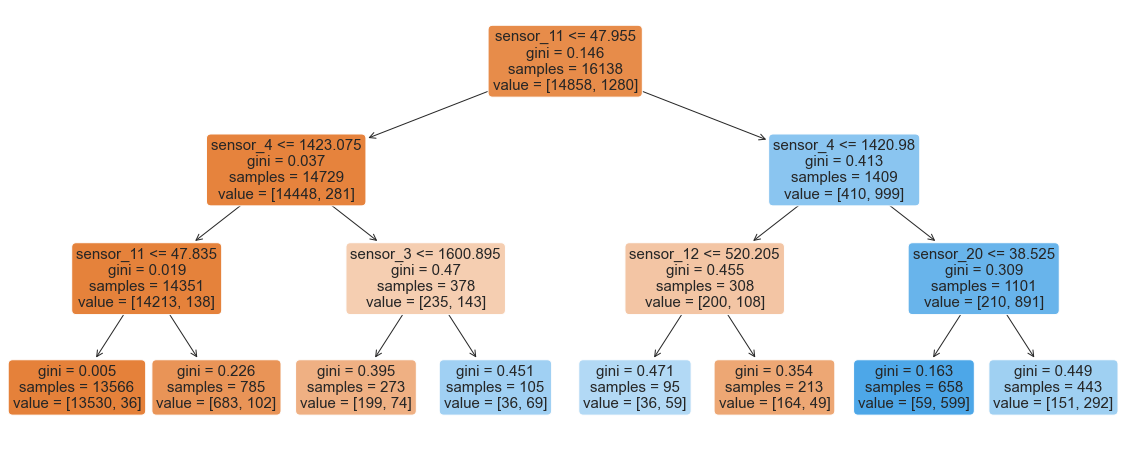

,5,2,10,1,6,0,3,4,7,8,9,11
sensor,sensor_11,sensor_4,sensor_20,sensor_3,sensor_12,sensor_2,sensor_7,sensor_8,sensor_13,sensor_15,sensor_17,sensor_21
coefficient,0.818145,0.131975,0.021897,0.014817,0.013166,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Select tree depths
max_depths = [1,2,3]

# Loop to run models and generate results
for max_depth in max_depths:
    print('-'*80)
    print(f"Decision tree branches in model: {max_depth}")
    # Instantiate
    DT_model = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf= 1, random_state=42)
    # Fit
    DT_model.fit(X_train, y_train)
    # Score
    model_scoring(DT_model, X_train, y_train, plot=True)
    plot_decision_tree(DT_model, X_train)

There is a plethora of information generated by the models.  The key results are summarize below: 

- All models have very high accuracies for Class 0 Normal predictions (e.g 98%) due to the class imbalance in the data
- As expected, the model with three branches, DT3, is the best for precision and recall and the composite F1 score for the Class 1 Failures
- In all models, `sensor 11` is the most important feature by far, at 81% in the DT3 model followed by sensor 4 at 13%, and sensors 3,12 and 20 making up the rest
    - this result is fully consistent with the findings in Parts 1 and 2

- The high explainability of the DT models are clear, as shown in the orange and blue plot of the decision tree logic
    - the first decision branch is very familiar => a `sensor 11` threshold of 47.955, about 0.02 higher than the value discovered through the statistical approach taken in Part 2
    - the second branches are interesting 
        - `sensor_4` which in the same group of sensors as `sensor_11`
    - the third branch brings in other sensors, namely `sensor_3` from the same group as 11, `sensor_12` and `sensor_20` from the other group, while `sensor_11` reappears with a different threshold

The business rules can be generated by following the tree to the blue boxes for DT3:

    - Business rule #1:   If sensor 11 > 47.955 and sensor 4 > 1420.98 then fail.
    - Business rule #2:   If sensor 11 > 47.955 and sensor 4 <= 1420.90 and sensor_12 <=520.21 then fail
    - Business rule #3:   If sensor 11 > 47.955 and sensor 4 <= 1423.07 then fail
    - Business rule #4:   If sensor 11 > 47.955 and sensor 4 > 1423.07 and sensor_3 > 1600.90 then fail

The outputs from the models are interesting but there are some aspects that need to be investigated further:
- Rebalance the data so the ratio of the Failure class: Normal class is closer to 1:1 => effectively down-sampling
    - this should increase the precision and recall scores, and decrease the accuracy, like the RUL threshold concept from Part 2.
- Tuning the Failure Threshold against the technical performance metrics and the business KPIs as per the Linear Regression modeling exercises
     - explore different thresholds so there is at most 1 failure in 100 (or 1 in 80) while maximizing the operating cycles



#### Step 5. Parameter Optimization Round 1 - Technical

[go to top](#Benchmark-against-the-sensor-flag) <br>

The two model parameters to explore are the RUL threshold for class imbalance and Failure Threshold values to see how they affect model performance. 

Two values for the RUL threshold will be tested:  361 for the full data set, and 50 for a subset as per guidance from Part 2.

Failure thresholds will be tested in a broader range from 20 to 4.  As the number decreases, the model will have fewer and fewer chances to positively flag that an engine belongs to the Failure class and should be removed from service.  At the same time, the relative operating efficiency will rise for engines not yet flagged prematurely.

Again, there is a plethora of data generated by the models.  Key results from the modeling output are summarized in the table below with the results sorted by F1 score.



##### Helper Functions


In [13]:
# Create feature df

def create_DT_feature_df(failure_df, RUL_threshold):
    """ This function subsets the main failure dataframe for just the targeted sensors and variables for modeling 
    and resets the RUL_threshold (total records to be used) as well
    """
    feature_df = failure_df[['unit_number','cycle_time','sensor_11','sensor_4', 'sensor_12', 'sensor_20','sensor_3', 
                            'RUL','Failure_Threshold','sensor_11_alert']]
    feature_df = feature_df[(feature_df['RUL']<= RUL_threshold)]
    
    return feature_df

In [14]:
# Technical scoring

def technical_score(y_actual, y_predicted):
    """ This function calculates the technical scores for the model used in the predictions
    """
    accuracy = accuracy_score(y_actual, y_predicted).round(3)
    precision = precision_score(y_actual, y_predicted).round(3)
    recall = recall_score(y_actual, y_predicted).round(3)
    f1 = f1_score(y_actual, y_predicted).round(3)
        
    return accuracy, precision, recall, f1

In [15]:
# Set thresholds to test
RUL_thresholds = [361,50]
failure_thresholds = [18,15,12,10,8,6]

# Collect results
results_summary = []

# Select data to train
for RUL_threshold in RUL_thresholds:
    
    # Create subset df
    feature_train = create_DT_feature_df(failure_train, RUL_threshold)

# Train models and score results
    for failure_threshold in failure_thresholds:
        
        # Set new threshold  
        set_thresholds(feature_train, failure_threshold)
        
        # Calculate class imbalance
        class_balance = feature_train['Failure_Threshold'].value_counts(normalize=True)
        
        # Split the data into X and y
        X_train, y_train = split_data(feature_train)

        # Instantiate
        DT_model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf= 20, random_state=42)

        # Fit
        DT_model.fit(X_train, y_train)

        # Predict
        y_pred = DT_model.predict(X_train)
        
        # Technical score(true labels, predicted labels)
        accuracy, precision, recall, f1 = technical_score(y_train, y_pred)
        
        # Compile results
        results = [RUL_threshold, failure_threshold, round(class_balance.iloc[0],2), accuracy, precision, recall,f1 ]
        results_summary.append(results)


In [16]:
# Summarized results
results_summary_df =pd.DataFrame(results_summary, columns = ['RUL_threshold', 'failure_threshold', 'class_0 balance', 'accuracy_score', 
                                                             'precision_score', 'recall_score', 'F1 score'])

display(results_summary_df.sort_values(by='F1 score', ascending=False))

,RUL_threshold,failure_threshold,class_0 balance,accuracy_score,precision_score,recall_score,F1 score
0,361,18,0.91,0.963,0.805,0.799,0.802
6,50,18,0.63,0.854,0.822,0.775,0.798
1,361,15,0.92,0.966,0.783,0.796,0.790
7,50,15,0.69,0.868,0.791,0.786,0.788
8,50,12,0.75,0.882,0.802,0.714,0.756
2,361,12,0.94,0.968,0.750,0.760,0.755
3,361,10,0.95,0.970,0.733,0.720,0.727
9,50,10,0.78,0.888,0.780,0.668,0.720
4,361,8,0.96,0.973,0.707,0.679,0.693
10,50,8,0.82,0.894,0.707,0.679,0.693


Key observations from the summary table are as follows:

- Subsetting the data at RUL=50 improves the class imbalance and the overall accuracy is lower as expected in each case.  However, there isn't much change in the precision, recall or F1 scores for labeling the Failure class.  The modeling seems insensitive to the imbalance in that regard

- In terms of Failure Thresholds, the larger the better in terms of F1 score.  However, this is moving in the opposite direction to the business need of getting closer to the RUL=0 value before flagging an engine for removal 

- Also, note that through inspection of the decision tress, the DT3 decision criteria are moving with these two parameters, e.g. the first decision value for sensor_11 now ranges between 47.915 and 48.015, which from the work in Part 2 is a significant shift.

The sensitivity of the business rules to the DT3 model parameters is somewhat concerning, suggesting that developing firm business rules from the DT3 models may not be feasible.

**Step 5. Parameter Optimization - Business**

A significant part of the model optimization is understanding how the model impacts the business KPIs.  To understand that space, the performance of the "best" technical model from the series above, with the full data set and Failure Threshold 18, can be scored as per the code blocks below. 

##### Helper functions

In [17]:
def plot_RUL_histogram(col):
    """ This function plots the histogram for a dataframe's RUL column
    """
    sns.set_style('darkgrid')

    plt.figure(figsize=(10,6))
    plt.hist(col, bins = 30)
    plt.axvline(col.mean(), label = 'mean', color = 'red')
    plt.axvline(col.median(), label = 'median', color = 'blue')
    plt.axvline(col.mode()[0], label = 'mode', color = 'black')
    plt.legend()
    plt.xlabel('Remaining Useful Life')
    plt.ylabel('Frequency')
    plt.xlim(0,150)
    plt.title(f'Remaining Useful Life Frequency')
    plt.show()

    return

In [18]:
def calculate_business_KPIs(df_train, engines_removed, engines_flagged_correctly):
    """ This function calculate three basic KPIs:  total operating cycles available, cycles sacrificied and operating efficiency
    """
    # Calculate Business KPIs
    total_operating_cycles = df_train.shape[0]-engines_flagged_correctly
    print(f"Total operating cycles for the fleet: {total_operating_cycles}")

    unused_cycles = engines_removed['RUL'].sum() 
    print(f"Cycles remaining: {unused_cycles}")

    op_efficiency = round((1-(unused_cycles/total_operating_cycles))*100,1)
    print(f"Operating efficiency: {op_efficiency} %")
    
    return

--------------------------------------------------------------------------------
Train data size: 16138
Failure threshold: 18
Class balance:


0    0.905812
1    0.094188
Name: Failure_Threshold, dtype: float64

Engines flagged before failure: 80


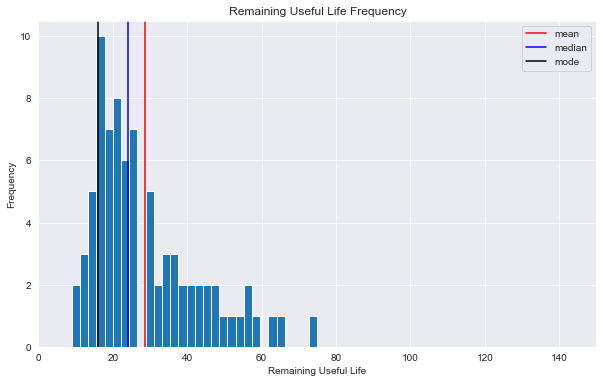

count    80.000000
mean     28.725000
std      14.449366
min       9.000000
25%      17.750000
50%      24.000000
75%      37.000000
max      75.000000
Name: RUL, dtype: float64

In [19]:
# Rerun the model from a business perspective 
failure_thresholds = [18]
RUL_threshold = 362

# Select data to train
for failure_threshold in failure_thresholds:

    # Create subset df
    feature_train = create_DT_feature_df(failure_train, RUL_threshold)
    set_thresholds(feature_train, failure_threshold)

    # Train model and score results
    print('-'*80)
    print(f"Train data size: {feature_train.shape[0]}")
    print(f"Failure threshold: {failure_threshold}")
    print("Class balance:")
    display(feature_train['Failure_Threshold'].value_counts(normalize=True))

    # Split the data into X and y
    X_train, y_train = split_data(feature_train)

    # Instantiate
    DT_model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf= 20, random_state=42)

    # Fit
    DT_model.fit(X_train, y_train)
    
# Summarize the results in a dataframe
DT_results_train = feature_train.copy()
DT_results_train['dtree_proba'] = DT_model.predict_proba(X_train)[:,1]

# Calculate how many engines were flagged before failure
true_positives = DT_results_train[(DT_results_train['Failure_Threshold']==1)& \
                                  (DT_results_train['dtree_proba']>=0.5)].sort_values(by='unit_number')
engines_flagged_correctly = true_positives['unit_number'].nunique()
print(f"Engines flagged before failure: {engines_flagged_correctly}")

# Show the histogram for RUL for engines removed
total_positives = DT_results_train[(DT_results_train['Failure_Threshold']<=1) & \
                                  (DT_results_train['dtree_proba']>=0.5)].sort_values(by='unit_number')

engines_removed = total_positives.groupby('unit_number')['RUL'].max().reset_index()

plot_RUL_histogram(engines_removed['RUL'])
display(engines_removed['RUL'].describe().T)
    

With 18 tries at correctly labeling the Failure class, the model was successful in flagging all of the engines. However, the distribution shows that the mean RUL value is quite high again at 28 cycles, with a median at 24, a maximum at 75 and minimum at 9 cycles, respectively.  This will translate into a significant loss in operating efficiency.

In [20]:
# Calculate Business KPIs
calculate_business_KPIs(feature_train, engines_removed, engines_flagged_correctly)

Total operating cycles for the fleet: 16058
Cycles remaining: 2298
Operating efficiency: 85.7 %


As expected, the model's performance from a business perspective is poor, with an operating efficiency of only 86%.  In fact, the sensor alert from Part 2 provided a similar level of performance when developed on the full data set.  This can be confirmed by re-scoring it on the same training data. 

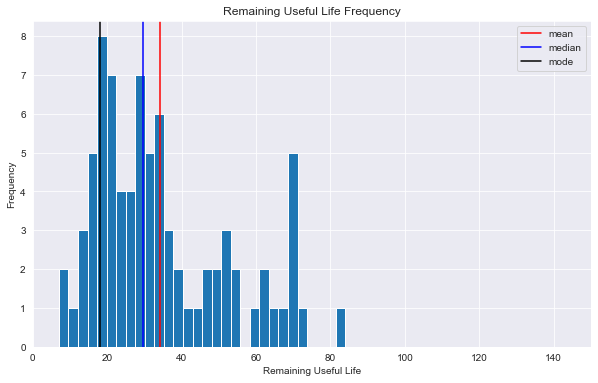

count    80.000000
mean     34.212500
std      18.242872
min       7.000000
25%      20.000000
50%      29.500000
75%      46.000000
max      84.000000
Name: RUL, dtype: float64

Total operating cycles for the fleet: 16058
Cycles remaining: 2737
Operating efficiency: 83.0 %


In [21]:
# Benchmark sensor_11 alert 

# Extract the max RULs for the engines at the cut off
sensor_engines_with_life = DT_results_train[(DT_results_train['sensor_11_alert'] ==1)]
sensor_engines_life_remaining = sensor_engines_with_life.groupby('unit_number')['RUL'].max().reset_index()

# Plot results
plot_RUL_histogram(sensor_engines_life_remaining['RUL'])

# Show stats
display(sensor_engines_life_remaining['RUL'].describe().T)

# Calculate Business KPIs
calculate_business_KPIs(feature_train, sensor_engines_life_remaining, engines_flagged_correctly)


The results are consistent with the outputs from Part 2, even without the 20 engines from the test set.  The Sensor Alert distribution is broader than the DT3 distribution and has a lower operating efficiency of 83% accordingly. However, one large advantage is that development and deployment of the Sensor Alert does not required data science techniques and advancing coding skills, nor any of the data science infrastructure overhead once deployed.

If the DT3 model is to be viable, the performance from a business perspective needs to improve.  

#### Step 5. Parameter Optimization, Round 3 - Technical & Business together



A better Failure Threshold needs to be found regardless of the technical f1 score.  There is a lot of information to collect about the models, so the results will be summarized in tabular form at the bottom.

In [22]:
def business_scoring(df, model, X, print_results = False):    
    """ The function calculates the set of business KPIs shown above
    """
    # set names
        
    # Business Scoring
    model_df = df.copy()
    model_df['dtree_proba'] = model.predict_proba(X)[:,1]

    # Calculate the true positives 
    true_positives = model_df[(model_df['Failure_Threshold']==1)& \
                                  (model_df['dtree_proba']>=0.5)].sort_values(by='unit_number')
    engines_flagged_correctly = true_positives['unit_number'].nunique()
    
    # Calculate the total postives (should be 80)
    total_positives = model_df[(model_df['Failure_Threshold']<=1) & \
                                      (model_df['dtree_proba']>=0.5)].sort_values(by='unit_number')
    flagged_engines = total_positives['unit_number'].nunique()
    
    # Calculate the RUL left on the engines removed
    engines_removed = total_positives.groupby('unit_number')['RUL'].max().reset_index()

    # Calculate the number of failed engines
    failed_engines = model_df['unit_number'].nunique()-total_positives['unit_number'].nunique()

    # Calculate the number of engines close to failure
    engines_close_to_failure = engines_removed['RUL'][engines_removed['RUL']<=3].nunique()

    # Calculate the engine closest to failure
    lowest_RUL = engines_removed['RUL'].min()
    
    # What was the percentage of cycles lost?
    total_operating_cycles = X.shape[0]-total_positives['unit_number'].nunique()
    adjusted_cycles_lost = engines_removed['RUL'].sum() 
    op_efficiency = round((1-(adjusted_cycles_lost/total_operating_cycles))*100,1)

    if print_results == True:
    # Print results summary
        print(f"Engines removed: {flagged_engines}")
        print(f"Failed_engines: {failed_engines}")
        print(f"Lowest RUL: {lowest_RUL}")
        print(f"Engines Close to Failure: {engines_close_to_failure}")
        print(f"Total operating cycles available {total_operating_cycles}")
        print(f"Cycles lost: {adjusted_cycles_lost}")
        print(f"Operating efficiency: {op_efficiency} %")
        
    return flagged_engines, engines_flagged_correctly,failed_engines,engines_close_to_failure, \
                lowest_RUL, total_operating_cycles,adjusted_cycles_lost, op_efficiency



In [23]:
# Set thresholds to test
failure_thresholds = [20,18,15,12,10,8,6,4]

# Collect results
business_results_summary = []

# Test thresholds and collect results
for failure_threshold in failure_thresholds:

    # Create subset df
    feature_train = create_DT_feature_df(failure_train, RUL_threshold)
    set_thresholds(feature_train, failure_threshold)

    # Split the data into X and y
    X_train, y_train = split_data(feature_train)

    # Instantiate
    DT_model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf= 20, random_state=42)

    # Fit
    DT_model.fit(X_train, y_train)
    
    # Predict
    y_pred = DT_model.predict(X_train)

    # Technical score(true labels, predicted labels)
    accuracy, precision, recall, f1 = technical_score(y_train, y_pred)
    
    # Business Scoring
    flagged_engines, engines_flagged_correctly,failed_engines,engines_close_to_failure, \
                lowest_RUL, total_operating_cycles,adjusted_cycles_lost, op_efficiency = business_scoring(feature_train, DT_model, X_train)
    
    # Compile results
   
    business_results_summary.append([split, failure_threshold, accuracy, f1, flagged_engines, engines_flagged_correctly,
            failed_engines,engines_close_to_failure, lowest_RUL, total_operating_cycles,adjusted_cycles_lost, op_efficiency])
                                     


In [24]:
# Convert results to a dataframe
columns = ['test split','failure_threshold','accuracy','F1','flagged engines','true positives','failed engines', 
           'engines near failure', 'lowest RUL','total op cycles','cycles lost','op efficiency']
DT_results_df = pd.DataFrame(business_results_summary, columns = columns)
DT_results_df

,test split,failure_threshold,accuracy,F1,flagged engines,true positives,failed engines,engines near failure,lowest RUL,total op cycles,cycles lost,op efficiency
0,81,20,0.960,0.801,80,80,0,0,9,16058,2440,84.8
1,81,18,0.963,0.802,80,80,0,0,9,16058,2298,85.7
2,81,15,0.966,0.790,80,80,0,0,9,16058,1954,87.8
3,81,12,0.968,0.755,80,80,0,0,4,16058,1660,89.7
4,81,10,0.970,0.727,80,80,0,1,3,16058,1454,90.9
5,81,8,0.973,0.693,80,80,0,2,1,16058,1288,92.0
6,81,6,0.976,0.646,80,80,0,3,1,16058,1036,93.5
7,81,4,0.981,0.537,75,73,5,4,0,16063,532,96.7


Observations from the tabular data are as follows:

- The operating efficiency business KPI is indeed moving in the opposite direction of the technical F1 score and the count of engines at risk of failing
- In theory, the Failure Threshold can be reduced to just 6 attempts at labeling the engine correctly, leading to an acceptably improved operating efficiency of 93.5% with three engines very close to failure yet none actually failed

Given that there are many parameters that need to be tuned in a multi-variate space, and given that there is a risk we have overfitted to our training data even with only a DT3 model, it is best to find a good middle ground for now. In that regard, a Failure Threshold of 10 seems more reasonable, with only 1 engine within 3 cycles of failure and an operating efficiency of 91%.

Recall that this operating efficiency is the same efficiency obtained in Part 2 with the tangential Linear Regression model that used the same concept of setting a threshold at RUL 15 and having multiple opportunities to correctly label the data.  However, recall that model missed labeling one engine by over 20 RUL cycles when it failed.  Clearly, the DT3 model using ML techniques is an improvement over that approach.

The true test of performance of the DT3 model however is how well it does with predicting values on the isolated test set.

First, the optimized DT3 model needs to be regenerated and its metrics reviewed.

In [25]:
### Rerun the code for finalized failure threshold 

failure_threshold = 10
DT3_results_summary = []

# Reset data to new threshold
feature_train = create_DT_feature_df(failure_train, RUL_threshold)
set_thresholds(feature_train, failure_threshold)

# Reset X_train, y_train
X_train, y_train = split_data(feature_train)

# Instantiate
DT_model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf= 20, random_state=42)

# Fit
DT_model.fit(X_train, y_train)

# Predict
y_pred = DT_model.predict(X_train)

# Technical score(true labels, predicted labels)
accuracy, precision, recall, f1 = technical_score(y_train, y_pred)

# Business Scoring
flagged_engines, engines_flagged_correctly,failed_engines,engines_close_to_failure, \
            lowest_RUL, total_operating_cycles,adjusted_cycles_lost, \
                op_efficiency = business_scoring(feature_train, DT_model, X_train, print_results=True)

# Compile results
DT3_results_summary.append([split, failure_threshold, accuracy, f1, flagged_engines, engines_flagged_correctly,
            failed_engines,engines_close_to_failure, lowest_RUL, total_operating_cycles,adjusted_cycles_lost, op_efficiency])


Engines removed: 80
Failed_engines: 0
Lowest RUL: 3
Engines Close to Failure: 1
Total operating cycles available 16058
Cycles lost: 1454
Operating efficiency: 90.9 %


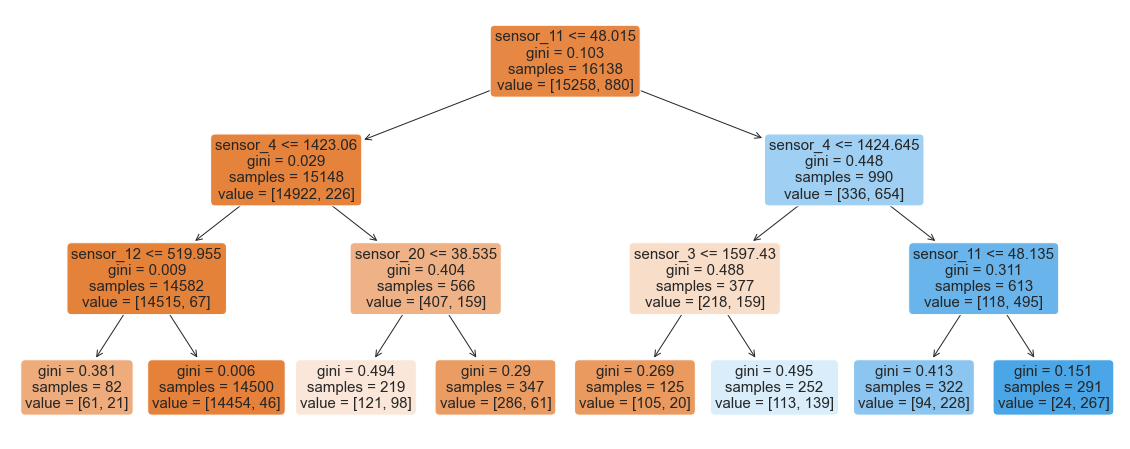

,0,1,4,3,2
sensor,sensor_11,sensor_4,sensor_3,sensor_20,sensor_12
coefficient,0.790777,0.153166,0.025707,0.019886,0.010466


In [26]:
plot_decision_tree(DT_model, X_train)

There are few interesting observations on this models parameters to note in passing before proceeding to the test set scoring

- the Class 1 precision, recall and f1 scores are low at 0.72-0.73, as expected
- most of the information is still in `sensor 11` followed by sensors 4 then 3,12 and 20,

- there are only two business rules given how the model treated the data 

        - Business rule #1:  If sensor 11 > 48.015 and sensor 4 > 1424.645 then fail
        - Business rule #2:  If sensor 11 > 48.015 and sensor 4 <= 1424.645 and sensor 3 > 1597.43 then fail

#### Step 6. Scoring the model against the test set


The test set data features need to be engineered as per the set of manipulations on the training set for the final DT3 model.

In [27]:
# Transform the data as per the training set
feature_test = create_DT_feature_df(failure_test, RUL_threshold)
set_thresholds(feature_test, failure_threshold)
X_test, y_test = split_data(feature_test)

In [28]:
# Score the model
y_pred = DT_model.predict(X_test)

# Technical score(true labels, predicted labels)
accuracy, precision, recall, f1 = technical_score(y_test, y_pred)

# print results for both train and test sets
print("Training set")
model_scoring(DT_model, X_train, y_train, plot=False)
print("Test set")
model_scoring(DT_model, X_test, y_test, plot=False)


Training set
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15258
           1       0.73      0.72      0.73       880

    accuracy                           0.97     16138
   macro avg       0.86      0.85      0.86     16138
weighted avg       0.97      0.97      0.97     16138

Test set
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4273
           1       0.66      0.75      0.70       220

    accuracy                           0.97      4493
   macro avg       0.82      0.87      0.84      4493
weighted avg       0.97      0.97      0.97      4493



The f1 score for the rest set is lower than the training set in particular with respect to precision for its predictions to belong to the Failure class not the Normal class.  

The business parameter scoring is shown below.

In [29]:
# Business Scoring
flagged_engines, engines_flagged_correctly,failed_engines,engines_close_to_failure, \
            lowest_RUL, total_operating_cycles,adjusted_cycles_lost, \
                op_efficiency = business_scoring(failure_test, DT_model, X_test, print_results=True)

Engines removed: 20
Failed_engines: 0
Lowest RUL: 4
Engines Close to Failure: 0
Total operating cycles available 4473
Cycles lost: 408
Operating efficiency: 90.9 %


The test set business results are quite acceptable: No failures, no engines close to failure with the lowest RUL at 4 cycles, a mean value of 20 and a maximum value of 33.  The train and test results are summarized in the table below for comparison.



In [30]:
# Compile results
DT3_results_summary.append([split, failure_threshold, accuracy, f1, flagged_engines, engines_flagged_correctly,
            failed_engines,engines_close_to_failure, lowest_RUL, total_operating_cycles,adjusted_cycles_lost, op_efficiency])

# Convert results to dataframe
columns = ['test split','failure_threshold','accuracy','f1','flagged engines','true positives','failed engines', 'engines near failure',
           'lowest RUL','total op cycles','cycles lost','op efficiency']
DT3_results_summary_df = pd.DataFrame(DT3_results_summary, columns = columns)
DT3_results_summary_df

,test split,failure_threshold,accuracy,f1,flagged engines,true positives,failed engines,engines near failure,lowest RUL,total op cycles,cycles lost,op efficiency
0,81,10,0.970,0.727,80,80,0,1,3,16058,1454,90.9
1,81,10,0.969,0.704,20,20,0,0,4,4473,408,90.9


The test scores appear equivalent to the training scores, with an operating effiency of 91% at the RUL=10 failure threshold and no immediate failures.

There are still opportunities to tune the DT3 model further, and additional work should be done to make sure that the train/test split has not introduced bias.  However, the results here will be considered to be sufficient for comparison to the other models in the case study.



In [31]:
#Save y_proba to append the main failure_test dataframe 
y_proba_DT = DT_model.predict_proba(X_test)[:,1]

### The Full Data Science ML solution

[go to top](#Table-of-Contents) <br>

One last step in our exploration of the solution options for the case study is to use the power of ML in an unrestricted fashion. If successful, it can be expected that the model would require full support from a data scientist to develop, manage and maintain the predictive model.  In addition, computational and deployment infrastructure would be needed to publish the results in a useable format for the business users (e.g. a web application) and to keep the model fresh once deployed.

Four basic classification techniques have been selected for testing on both the train and the test set that we have now seen: the Logistic Regression model, the k-Nearest Neighbour model, the Support Vector Classifier, and an unrestricted Decision Tree.

For the three new models, scaling of the data is required and standard scaling is appropriate.  The decision tree models do not required scaled data but it does not affect the results if they are scaled in this screening situation.

In [32]:
### Use same subsetted training and test data as above for DT3

# Instantiate
ss = StandardScaler()

# Fit (training data only)
ss.fit(X_train)

# Transform (both)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

Default parameters for each model will be used and the DT model will be allowed to use up to 5 branches. The models will be scored on the ROC plots that calculate how well the model labels the data, with an important differentiator being the Area Under the Curve (AUC) score and how those scores differ for the train and test sets.

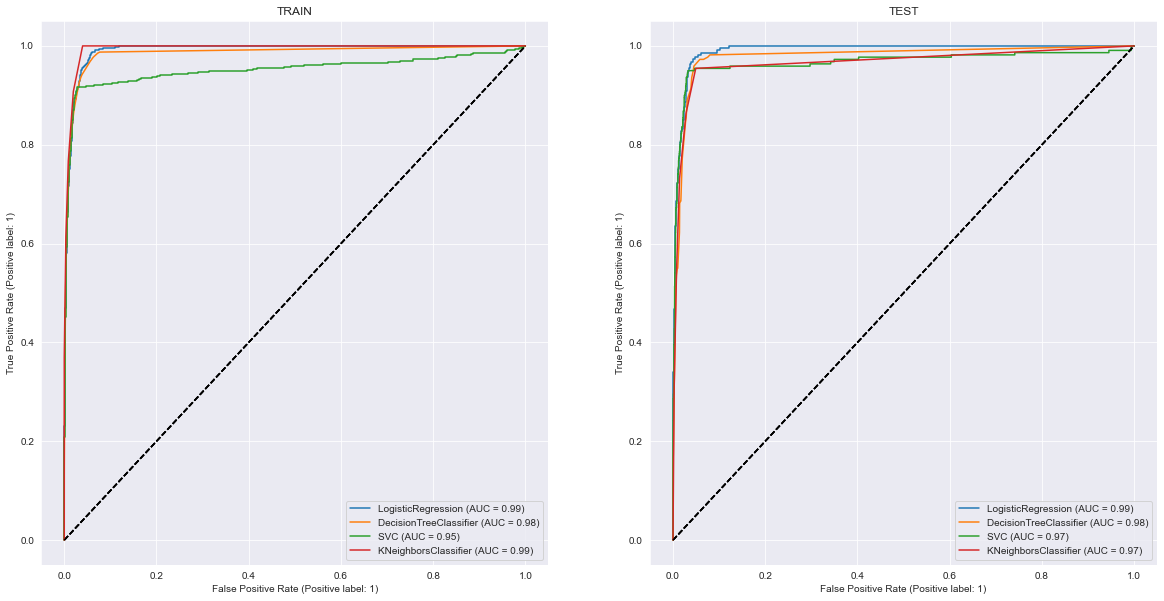

In [33]:
# Create a list of model types - (instantiate)
my_model_list = [LogisticRegression(), DecisionTreeClassifier(max_depth=5), 
                 SVC(probability=True), KNeighborsClassifier()]

# Create subplots
figs, axes = plt.subplots(1, 2, figsize=(20, 10))

# Test each model
for model in my_model_list:

    # Fit
    model.fit(X_train_ss, y_train)

    # Plot ROC Curve for train & test
    plot_roc_curve(model, X_train_ss, y_train, ax=axes[0])
    plot_roc_curve(model, X_test_ss, y_test, ax=axes[1])
    
    # Add line y=x and titls
    for axis_num, plot_title in enumerate(['TRAIN', 'TEST']):
        axes[axis_num].plot([0,1], [0,1], color='black', linestyle='--')
        axes[axis_num].set_title(plot_title)

From the charts, it looks like Logistic Regression is the best choice.  Other experiences with SVC and kNN models support this as while those algorithms might offer similar AUC scores, they are computational intensive and slow to test.

The Logistic Regression modeling will be restarted from the top using the full dataset and the same optimization parameters as our benchmark DT3 model in order to facilitate comparison between them.

#### Step 2. Feature extraction and creation 

In [34]:
# Set Failure threshold
failure_threshold = 10

# Set thresholds in training set
failure_train = set_thresholds(failure_train, failure_threshold)

# Set thresholds in test set
failure_test = set_thresholds(failure_test, failure_threshold)

#### Step 3. Prepare the data for first model

The data must be separated into target variable and feature dataframes as before.  As mentioned, Logistic Regression models required scaled data as well. In addition, a new option to try is Principal Component Analysis: PCA will be used to create composite vectors from all of the sensor data to a threshold value of 85% of the total variance in the data.   

In [35]:
# Split the data into X and y
X_train, y_train = split_data(failure_train)
X_test, y_test = split_data(failure_test)

# Save column names for future use
X_columns = X_train.columns

In [36]:
from sklearn.decomposition import PCA # Local Environment glitch that this needs to be reimported each time

# Set PCA threshold
component_threshold = 0.85

# Fit the Scaler 
scaler = StandardScaler()
scaler.fit(X_train)

# Scale the data
X_train_ss = scaler.transform(X_train)
X_test_ss = scaler.transform(X_test)

# Instantiate and Fit Model
PCA = PCA(n_components = component_threshold)
PCA.fit(X_train_ss)

# transform data 
X_train = PCA.transform(X_train_ss)
X_test = PCA.transform(X_test_ss)


The PCA transformation results can be visualized to see how many components were needed to reach the 85% threshold.

In [37]:
# Count the PC vectors
expl_var = PCA.explained_variance_ratio_
print(f"PC weights: {expl_var}")
print(f"Total explained variance: {np.sum(expl_var)*100} %")

PC weights: [0.74029424 0.04183677 0.03329724 0.03009007 0.02776017]
Total explained variance: 87.32784933129916 %


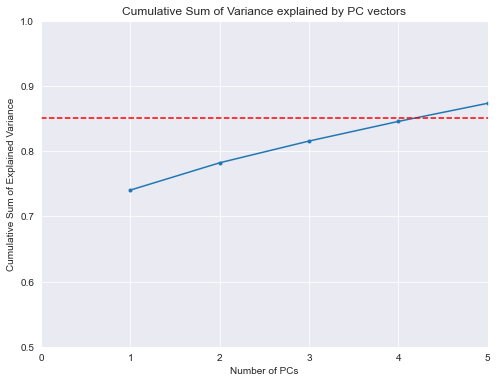

In [38]:
# Plot the PCA curve to help pick
sns.set_style('darkgrid')

# Collect the coefs for each PC
expl_var = PCA.explained_variance_ratio_
length = expl_var.shape[0]

# Calculate the cumulative sum  
cumulative_sum = np.cumsum(expl_var)

# Plot out the cumulative sum graph
plt.figure()
plt.plot(range(1,length+1), cumulative_sum, marker='.')
plt.axhline(0.85, c='red', linestyle='--')
plt.title("Cumulative Sum of Variance explained by PC vectors")
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.xlim(0,length)
plt.ylim(0.5,1)
# plt.xticks(range(1,31,2))
plt.show()

Five components were selected.  Interestingly, just one component explains 74% of the variance, with four more components making up the variance to 87%.  This pattern appears similar to the feature importance lists from the DT3 exercises, where `sensor_11` contained ~80% of the information.  

However, and somewhat surprisingly, the heatmap below shows that PC1 is in fact a healthy and equal blend of all of the 12 sensors.


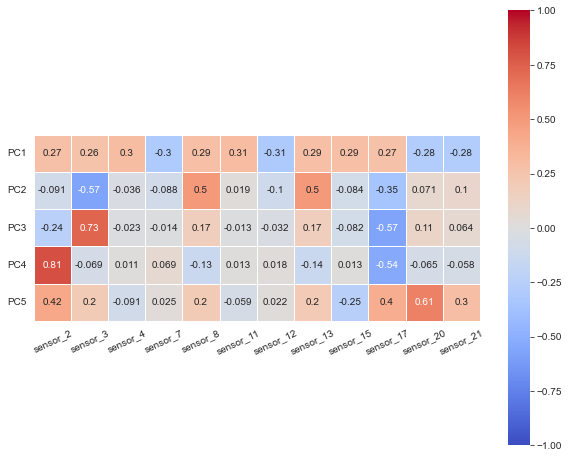

In [39]:
# Create a heatmap of the PCA components
plt.figure(figsize=(10,8))
ax = sns.heatmap(PCA.components_,
                 cmap='coolwarm',
                 yticklabels=[ "PC"+str(x) for x in range(1,PCA.n_components_+1)],
                 xticklabels=list(X_columns),
                 linewidths = 1,
                 annot = True,
                 vmin=-1,
                 vmax=1,
                 cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=0)
plt.xticks(rotation=25)
ax.set_aspect("equal")

PC2 is based on sensors 3, 8 and 13, PC3 is comprised mostly of `sensor_3` and `sensor_17` information while PC4 and PC5 are associated primarily with `sensor_2` and `sensor_20` respectively.  Our main 'alert' `sensor_11` is not as prevalent in the scaled and transformed data, which is an interesting contrast to all modeling work done prior to this.

Given the blended PCA vectors, the resulting Logistic Regression model should perform differently than all others attempted so far.


#### Step 4. Build the first Logistic Regression Model

The Logistic Regression, or Logit model, can be configured with Ridge Regression to reduce the odds of overfitting to the training set. A default value of C=1 will be used to start.

Selected C hyperparameter for modeling: 1


<Figure size 576x432 with 0 Axes>

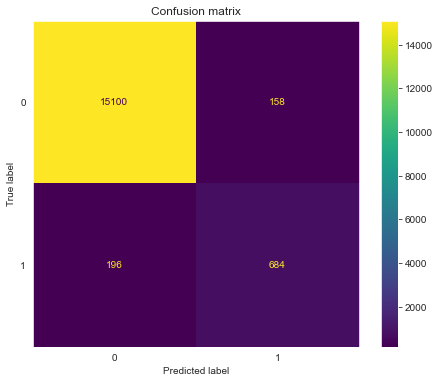

Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15258
           1       0.81      0.78      0.79       880

    accuracy                           0.98     16138
   macro avg       0.90      0.88      0.89     16138
weighted avg       0.98      0.98      0.98     16138



In [40]:
# Set hyperparameters
c_selected = 1
penalty = 'l2'

# Instantiate and Fit model
logreg_PCA_model = LogisticRegression(C=c_selected, solver='lbfgs', penalty=penalty, max_iter=2000)
logreg_PCA_model.fit(X_train,y_train)

# Print results
print(f"Selected C hyperparameter for modeling: {c_selected}")
model_scoring(logreg_PCA_model, X_train, y_train)
 

As per the screening process, the model accuracy is very high due to the aforementioned class imbalance. The precision, recall and F1 scores are higher than the DT3 model as per the model screening process.

Having said that, the previous ML modeling work has shown that the true test of performance for the case study are on how well the model can label records as failures as the RUL threshold is passed and the countdown to zero begins.

In [41]:
# Collect results
logreg_PCA_results_summary =[]

# Predict
y_proba_PCA = logreg_PCA_model.predict_proba(X_train)[:,1]
y_pred = logreg_PCA_model.predict(X_train)

# Technical score(true labels, predicted labels)
accuracy, precision, recall, f1 = technical_score(y_train, y_pred)


# Business Scoring
flagged_engines, engines_flagged_correctly,failed_engines,engines_close_to_failure, \
            lowest_RUL, total_operating_cycles,adjusted_cycles_lost, \
                op_efficiency = business_scoring(feature_train, logreg_PCA_model, X_train, print_results=True)

# # Business Scoring 
# logreg_PCA_results_train = feature_train.copy()
# logreg_PCA_results_train['logreg_PCA_proba'] = y_proba_PCA  #DT_model.predict_proba(X_test)[:,1]

# # Calculate the true positives 
# true_positives = logreg_PCA_results_train[(logreg_PCA_results_train['Failure_Threshold']==1)& \
#                               (logreg_PCA_results_train['logreg_PCA_proba']>=0.5)].sort_values(by='unit_number')
# engines_flagged_correctly = true_positives['unit_number'].nunique()
    
# # Calculate the total postives (should be 80)
# total_positives = logreg_PCA_results_train[(logreg_PCA_results_train['Failure_Threshold']<=1) & \
#                                       (logreg_PCA_results_train['logreg_PCA_proba']>=0.5)].sort_values(by='unit_number')

# # Calculate the RUL left on the engines removed
# engines_removed = total_positives.groupby('unit_number')['RUL'].max().reset_index()

# # Plot the results
# plot_RUL_histogram(engines_removed['RUL'])
# display(engines_removed['RUL'].describe().T)

# # Calculate the number of failed engines
# failed_engines = logreg_PCA_results_train['unit_number'].nunique()-total_positives['unit_number'].nunique()

# # Calculate the number of engines close to failure
# engines_close_to_failure = engines_removed['RUL'][engines_removed['RUL']<=3].nunique()

# # Print results summary
# print(f"Engines removed: {total_positives['unit_number'].nunique()}")
# print(f"Failed_engines: {failed_engines}")
# print(f"Lowest RUL: {engines_removed['RUL'].min()}")
# print(f"Engines Close to Failure: {engines_close_to_failure}")

# # What was the percentage of cycles lost?
# total_operating_cycles = X_train.shape[0]-total_positives['unit_number'].nunique()
# print(f"Total operating cycles available: {total_operating_cycles}")
# adjusted_cycles_lost = engines_removed['RUL'].sum() 
# print(f"Cycles lost: {adjusted_cycles_lost}")
# op_efficiency = round((1-(adjusted_cycles_lost/total_operating_cycles))*100,1)
# print(f"Operating efficiency: {op_efficiency} %")


logreg_PCA_results_summary.append([split, failure_threshold, accuracy, f1, flagged_engines, engines_flagged_correctly,
            failed_engines,engines_close_to_failure, lowest_RUL, total_operating_cycles,adjusted_cycles_lost, op_efficiency])

Engines removed: 80
Failed_engines: 0
Lowest RUL: 3
Engines Close to Failure: 1
Total operating cycles available 16058
Cycles lost: 1062
Operating efficiency: 93.4 %


The results are impressive: No failures, one engine close to failure with 3 cycle remaining, and a tight distribution of remaining useful lives with a mean RUL for engines removed from service of 13 and a maximum of 33.  The operating efficiency is now 93.4%.

The final test of this model is with the test data set.

#### Step 6. Scoring the model against the test set

In [42]:
logreg_PCA_model

LogisticRegression(C=1, max_iter=2000)

In [43]:
# Technical score(true labels, predicted labels)
accuracy, precision, recall, f1 = technical_score(y_train, y_pred)

# Business Scoring
flagged_engines, engines_flagged_correctly,failed_engines,engines_close_to_failure, \
            lowest_RUL, total_operating_cycles,adjusted_cycles_lost, \
                op_efficiency = business_scoring(feature_train, logreg_PCA_model, X_train, print_results=True)

Engines removed: 80
Failed_engines: 0
Lowest RUL: 3
Engines Close to Failure: 1
Total operating cycles available 16058
Cycles lost: 1062
Operating efficiency: 93.4 %


In [44]:
# Score the model
y_pred = logreg_PCA_model.predict(X_test)

# Technical score(true labels, predicted labels)
accuracy, precision, recall, f1 = technical_score(y_test, y_pred)

# Technical score(true labels, predicted labels)
# accuracy = accuracy_score(y_test, y_pred).round(3)
# precision = precision_score(y_test,y_pred).round(3)
# recall = recall_score(y_test,y_pred).round(3)
# f1 = f1_score(y_test,y_pred).round(3)

print("Training set")
model_scoring(logreg_PCA_model, X_train, y_train, plot=False)
print("Test set")
model_scoring(logreg_PCA_model, X_test, y_test, plot=False)


Training set
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     15258
           1       0.81      0.78      0.79       880

    accuracy                           0.98     16138
   macro avg       0.90      0.88      0.89     16138
weighted avg       0.98      0.98      0.98     16138

Test set
Classification Report
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4273
           1       0.81      0.80      0.81       220

    accuracy                           0.98      4493
   macro avg       0.90      0.90      0.90      4493
weighted avg       0.98      0.98      0.98      4493



The model's technical scores

In [45]:
y_proba_PCA = logreg_PCA_model.predict_proba(X_test)[:,1]

# Business Scoring
flagged_engines, engines_flagged_correctly,failed_engines,engines_close_to_failure, \
            lowest_RUL, total_operating_cycles,adjusted_cycles_lost, \
                op_efficiency = business_scoring(failure_test, logreg_PCA_model, X_test, print_results=True)

# Compile results
logreg_PCA_results_summary.append([split, failure_threshold, accuracy, f1, flagged_engines, engines_flagged_correctly,
            failed_engines,engines_close_to_failure, lowest_RUL, total_operating_cycles,adjusted_cycles_lost, op_efficiency])

Engines removed: 20
Failed_engines: 0
Lowest RUL: 4
Engines Close to Failure: 0
Total operating cycles available 4473
Cycles lost: 271
Operating efficiency: 93.9 %


The results remain impressive: No failures, a tight distribution of RUL on the engines removed from service and an operating efficiency of 94%.  The results for the test and train sets are summarized together below.

In [46]:
# Convert to dataframe
columns = ['test split','failure_threshold','accuracy','F1','flagged engines','true positives','failed engines', 'engines near failure',
           'lowest RUL','total op cycles','cycles lost','op efficiency']
logreg_PCA_results_summary_df = pd.DataFrame(logreg_PCA_results_summary, columns = columns)
logreg_PCA_results_summary_df

,test split,failure_threshold,accuracy,F1,flagged engines,true positives,failed engines,engines near failure,lowest RUL,total op cycles,cycles lost,op efficiency
0,81,10,0.978,0.794,80,80,0,1,3,16058,1062,93.4
1,81,10,0.981,0.806,20,20,0,0,4,4473,271,93.9


Note that manually adjusting the C value in the code block above shows that the efficiencies can be improved to 96% without failures when the C value is set to 0.001, however the number of engine near failure rises as well.  Further work would be needed to fully explore the multi-variate parameter space for this model. 

For now, setting the Ridge Regression hyperparameter to 1 is conservative in keeping with the treatments of the other models in the case study. 

### Summary

[go to top](#Table-of-Contents) <br>

The ML modeling exercises have proven to be worthwhile despite the clear complexity in the coding and optimization process.  Both the restricted DT3 model and the Logit model improved on the performance of the sensor alert developed from statistical techniques in Part 2, and also on the Risk-Adverse Weibull business rule of removing every engine after 131 cycles of operation.

It is fair to say that there is a lot more work required to take these initial models and fully develop them into deployable solutions.  One big concern is that that the models may be sensitive to the choice to isolate the last 20 engines as the test set.  Cross-validation is a technique to help prevent over-fitting but it would be a signficant effort to build a cross-validation exercise that would a) properly subset the data into engine groups, b) accommodate a custom GridSearch process to also include the Failure Threshold parameter for tuning and the Business KPIs for scoring in addition to the traditional technical scorings of accuracy, precision and recall.  

Having said that, such exercises would be justified if the client is impressed with these initial results.

As a final step, the soft probabilities from both models can be saved for the test set with the other sensor alert generated from Part 2.  These will be compared together and used again in Part 4 in the final chapter of our study.


In [47]:
# Save the DT_model results from DT_test
failure_test['dtree_proba'] = y_proba_DT.round(4)

# Save the logreg_model results from logreg_PCA_test
failure_test['logit_proba'] = y_proba_PCA.round(4)

In [48]:
display(failure_test.tail(12))

,unit_number,cycle_time,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_15,sensor_17,sensor_20,sensor_21,RUL,Failure_Threshold,sensor_11_alert,dtree_proba,logit_proba
20619,100,189,643.69,1599.85,1423.15,551.61,2388.18,47.99,519.50,2388.24,8.4870,397,38.65,23.0591,11,0,1,0.1758,0.6269
20620,100,190,643.12,1594.45,1426.04,551.06,2388.21,47.99,519.52,2388.26,8.5162,395,38.42,23.0603,10,1,1,0.4475,0.5940
20621,100,191,643.69,1610.87,1427.19,551.78,2388.26,48.07,519.80,2388.28,8.5092,398,38.39,23.1218,9,1,1,0.7081,0.9808
20622,100,192,643.53,1601.23,1419.48,551.14,2388.17,48.18,520.59,2388.21,8.4892,397,38.56,23.0770,8,1,1,0.5516,0.6292
20623,100,193,643.09,1599.81,1428.93,552.04,2388.29,48.19,520.11,2388.19,8.5424,397,38.47,23.0230,7,1,1,0.9175,0.9072
20624,100,194,643.72,1597.29,1427.41,551.99,2388.23,48.12,519.55,2388.22,8.5215,394,38.38,23.1324,6,1,1,0.7081,0.6737
20625,100,195,643.41,1600.04,1431.90,551.42,2388.23,48.22,519.71,2388.28,8.5519,394,38.14,23.1923,5,1,1,0.9175,0.9467
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4,1,1,0.7081,0.9154
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3,1,1,0.7081,0.9430
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2,1,1,0.7081,0.9950


In [49]:
# Write the results back to the failure_test dataframe and save the results
failure_test.to_csv('./data/failure_test_with_models_threshold10.csv', index=False)